In [1]:
import sys
!pip install pyspark 
from pyspark import SparkContext, SparkConf
import matplotlib.pyplot as plt
sc = SparkContext("local","Project3-K-means++")

In [2]:
#This should be used only when running this on google colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#import the input file. I have just considered just a small portion of the file as system has very less resources. You can use the main input file path
file1 = '/content/gdrive/My Drive/CS5683/data.txt'
fileRDD = sc.textFile(file1, minPartitions=20)

In [4]:
items = fileRDD.map(lambda line:line.split())

data = items.map(lambda x: [float(i) for i in x]).zipWithIndex().map(lambda x:(x[1],x[0]))

In [6]:
columns = len(items.take(1)[0])

In [11]:
centroids = items.map(lambda x: [float(i) for i in x]).takeSample(False, 1)
centroids[0] = (0,centroids[0])
k= 10
while len(centroids) < k:
  def distance(x):
    list1 = []
    for j in centroids:
      count = 0
      for i in range(0,columns):
        count = count + (j[1][i]-x[1][i]) * (j[1][i]-x[1][i])
      list1.append([j[0],count])
    return (x[0],list1)
  max_distance = data.map(distance).map(lambda a: (a[0], max((x for x in a[1]), key=lambda k:k[1]))).max(key = lambda x: x[1][1])
  #print(max_distance)
  new_centroid = data.filter(lambda x: x[0] == max_distance[0]).map(lambda x: (len(centroids), x[1])).collect()
  centroids = centroids + new_centroid

In [13]:
centroids_list = sc.broadcast(centroids)
centroids_list_man = sc.broadcast(centroids)

In [14]:
with open("/content/gdrive/My Drive/CS5683/Kmeansplusplus_centroids.txt", 'w') as output:
    for row in centroids_list.value:
        output.write(str(row) + '\n')

In [15]:
def Euclidian_distance(x):
  list1 = []
  for j in centroids_list.value:
    count = 0
    for i in range(0,columns):
      count = count + (j[1][i]-x[1][i]) * (j[1][i]-x[1][i])
    count = count**.5 #"{:.2f}".format(6.737391260718053)
    list1.append([j[0],count])
  return (x[0],list1)

In [16]:
maxiterations = 20
cost_functions_eu = {}
for i in range(0,maxiterations):
  assigned_clusters = data.map(Euclidian_distance).map(lambda a: (a[0], min((x for x in a[1]), key=lambda k:k[1])))
  #print(assigned_clusters.take(2))
  cost_function_eu = assigned_clusters.map(lambda x: x[1][1]*x[1][1]).sum()
  cost_functions_eu[i+1]  = cost_function_eu
  #new_centroids 
  new_centroids = assigned_clusters.join(data).map(lambda x: (x[1][0][0],x[1][1])).groupByKey().map(lambda x: (x[0], list(x[1]))).map(lambda c: (c[0], [sum(col)/len(col) for col in zip(*c[1])]))
  #print(centroids1.take(2))
  centroids_list = sc.broadcast(new_centroids.collect())
  print('iter #' + str(i+1) + ' : ' + str(cost_function_eu))

iter #1 : 1807102384.9008822
iter #2 : 1167783732.6158426
iter #3 : 827880471.3684412
iter #4 : 660996622.9348587
iter #5 : 591977608.0604535
iter #6 : 559878319.6904585
iter #7 : 549653745.78287
iter #8 : 547306798.2527115
iter #9 : 542218521.9513689
iter #10 : 541487594.6416845
iter #11 : 541374431.9798056
iter #12 : 541333810.2743198
iter #13 : 541313766.2138975
iter #14 : 541300769.0025487
iter #15 : 541296695.7046793
iter #16 : 541294768.3806859
iter #17 : 541294768.3806859
iter #18 : 541294768.3806859
iter #19 : 541294768.3806859
iter #20 : 541294768.3806859


In [17]:
perc_change = (cost_functions_eu[1]-cost_functions_eu[10])/cost_functions_eu[1]
perc_change

0.7003558851086433

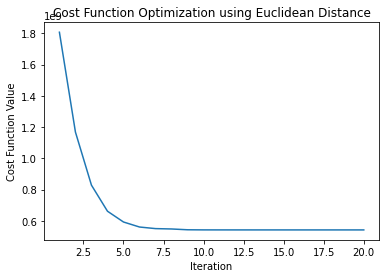

In [18]:
plt.title('Cost Function Optimization using Euclidean Distance')
plt.ylabel('Cost Function Value')
plt.xlabel('Iteration')
plt.plot(list(cost_functions_eu.keys()),list(cost_functions_eu.values()))

In [19]:
def manhattan_distance(x):
  list1 = []
  for j in centroids_list_man.value:
    count = 0
    for i in range(0,columns):
      count = count + abs(j[1][i]-x[1][i])
    count = count**.5 #"{:.2f}".format(6.737391260718053)
    list1.append([j[0],count])
    
  return (x[0],list1)

In [20]:
maxiterations = 20
cost_functions_man = {}
for i in range(0,maxiterations):
  assigned_clusters_man = data.map(manhattan_distance).map(lambda a: (a[0], min((x for x in a[1]), key=lambda k:k[1])))#centroids1.cartesian(data).map(distance).groupByKey().map(lambda x: (x[0], list(x[1]))).map(lambda a: (a[0], min((x for x in a[1]), key=lambda k:k[1])))
  #print(assigned_clusters.take(2))
  cost_function_man = assigned_clusters_man.map(lambda x: x[1][1]*x[1][1]).sum()
  cost_functions_man[i+1]  = cost_function_man
  #new_centroids 
  new_centroids_man = assigned_clusters_man.join(data).map(lambda x: (x[1][0][0],x[1][1])).groupByKey().map(lambda x: (x[0], list(x[1]))).map(lambda c: (c[0], [sum(col)/len(col) for col in zip(*c[1])]))
  #print(centroids1.take(2))
  centroids_list_man = sc.broadcast(new_centroids_man.collect())
  print('iter #' + str(i+1) + ' : ' + str(cost_function_man))

iter #1 : 1555391.73
iter #2 : 1213041.3735680995
iter #3 : 967138.3425643255
iter #4 : 983722.9580789359
iter #5 : 1027007.3543159593
iter #6 : 1076467.1676468123
iter #7 : 1106208.012637696
iter #8 : 1126282.8093678206
iter #9 : 1140577.6566740319
iter #10 : 1159556.7920603869
iter #11 : 1167828.1464454744
iter #12 : 1176951.1222358735
iter #13 : 1182022.6579219694
iter #14 : 1182744.6729112603
iter #15 : 1183469.97533879
iter #16 : 1183469.97533879
iter #17 : 1183469.97533879
iter #18 : 1183469.97533879
iter #19 : 1183469.97533879
iter #20 : 1183469.97533879


In [21]:
perc_change_man = (cost_functions_man[1]-cost_functions_man[10])/cost_functions_man[1]
perc_change_man

0.254492119448014

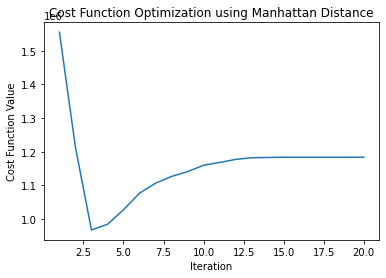

In [22]:
plt.title('Cost Function Optimization using Manhattan Distance')
plt.ylabel('Cost Function Value')
plt.xlabel('Iteration')
plt.plot(list(cost_functions_man.keys()),list(cost_functions_man.values()))